Connected to venv (Python 3.10.12)

### Simulated reference tracking with a 1R robot
This jupyter notebook simulates tracking control for a 1R robot using adaptive Koopman model predictive control (KMPC). The dynamic parameters of the simulated system correspond to those of the real system, which was used for the experiments shown in the [adaptive KMPC paper](https://arxiv.org/abs/2503.17902). The used reference trajectory also corresponds to the one used for the real system experiments.   

First, the reference trajectory is loaded and a dynamic model for simulations is built:

In [1]:
from adaptive_kmpc_py.controller import adaptiveKMPC
from adaptive_kmpc_py.predictor import EDMD 
import dynamics as dyn 
import matplotlib.pyplot as plt
import pykoopman as pk 
import numpy as np 

# load reference trajectory
Xref = np.loadtxt("./trajectories/Xref_1R.txt")
Tref = np.loadtxt("./trajectories/Tref_1R.txt")
  
# build single pendulum
m1 = 0.27                                                       # link 1 mass 
l1 = 0.4                                                        # link 1 length 
lc = 0.131                                                      # distance rotational axis to center of mass (COM) of link 1
I1 = 0.007479                                                   # moment of inertia of link 1 expressed in COM frame 
m_dof = 1;                                                      # number of DOF
n = 2
sp = dyn.nPendulum(m1,l1,lc,I1,n,m_dof)

Then a set of parameters used for the predictive controller is defined, and we need to specify a dictionary of lifting functions that are used for obtaining a data-driven linear model via extended dynamic mode decomposition (EDMD). The lifting builds on functionality provided by the **pykoopman** package and creating overservables can be done according to [this tutorial](https://pykoopman.readthedocs.io/en/master/tutorial_compose_observables.html). 

In [2]:
# choose basis functions for EDMD
observables = [lambda x1,x2: np.sin(x1),                        # sin(θ1)
               lambda x1,x2: np.cos(x1),                        # cos(θ1)
               lambda x1,x2: x2*np.sin(x1),                     # ω1*sin(θ1)
               lambda x1,x2: x2*np.cos(x1)]                     # ω1*cos(θ1)

observable_names = [
    lambda s,t: f"sin{s}",
    lambda s,t: f"cos{s}",
    lambda s,t: f"{t}*sin{s}",
    lambda s,t: f"{t}*cos{s}",
]
obs = pk.observables.CustomObservables(observables, observable_names=observable_names)


Nb = 500                                                                # length of circular buffer, containing data used for EDMD
edmd = EDMD(sp.n, sp.m_dof, Nb, obs)                                    # circular buffer is created within EDMD class    

# Controller parameters
Q = np.concatenate(([1], np.zeros(5)))                                  # weights on tracking error (with these weights emphasis is put only on tracking of the joint angle θ1)
Qf = np.concatenate(([1], np.zeros(5)))                                 # weights on tracking error, final state
R = np.ones(m_dof) * 1                                                  # weights on control effort
H = 30                                                                  # prediction horizon
ul = np.array([-6.0])                                                   # lower limit on controls
uu = np.array([6.0])                                                    # upper limit on controls

ctrl = adaptiveKMPC(edmd, Q, Qf, R, Xref, H, ul, uu)                    # build controller 

The simulated control experiment starts by inputting a sequence of N feed forward controls to the system. For the purpose of this tutorial, we use a sinusoidal torque sequence, such that the system oscillates around its stable equilibrium point. The system response is measured and data are used to fill the circular buffer, providing an initial internal model, such that actual tracking can be carried out. Note that control frequency and discretization of the reference trajectory have to match for the internal model to produce useful predictions.         

In [3]:
# Preceding experiment for gathering data 
h = Tref[2]-Tref[1]                                                     # discretization step length of the reference trajectory determines control freq. 
X_p = np.zeros((sp.n, Nb))                                  
U_p = np.zeros((m_dof, Nb-1))     
T_p = np.linspace(0,h*(Nb-1),Nb)

x0 = np.zeros(2)                                                        # initial state 
X_p[:,1] = x0
for i in range(Nb-1):
    U_p[:,i] = 0.15*np.cos(2*np.pi*0.05*(i+1)*h)           
    X_p[:,i+1] = dyn.simulate(X_p[:,i], U_p[:,i], h, sp)

# fill circular buffer 
ctrl.update_buffer(X_p, U_p, T_p)

# Reference tracking 
N = 500                                                                 # duration of the tracking process is given by h*(N-1) (when the reference trajectory ends, the controller will track the last state)
X_a = np.zeros((sp.n, N))
U_a = np.zeros((m_dof, N-1))    
T_a = np.linspace(0,h*(N-1),N)

X_a[:,0] = X_p[:,-1]                                                    # assumption: the tracking process starts immediately after preceding experiment 
for i in range(N-1):
    U_a[:,i] = ctrl.get_control(X_a[:,i], i)                            # this function carries out the EDMD, building and solving of the MPC problem. Variable names inside the function are chosen according to the notation in the paper. 
    X_a[:,i+1] = dyn.simulate(X_a[:,i], U_a[:,i], h, sp)                # apply control 
    ctrl.update_buffer(X_a[:,i+1].reshape((n,1)), U_a[:,i].reshape((m_dof,1)), np.array([T_a[i]]))                        # buffer is updated in every time step to provide new data for the EDMD 

Plotting the results:

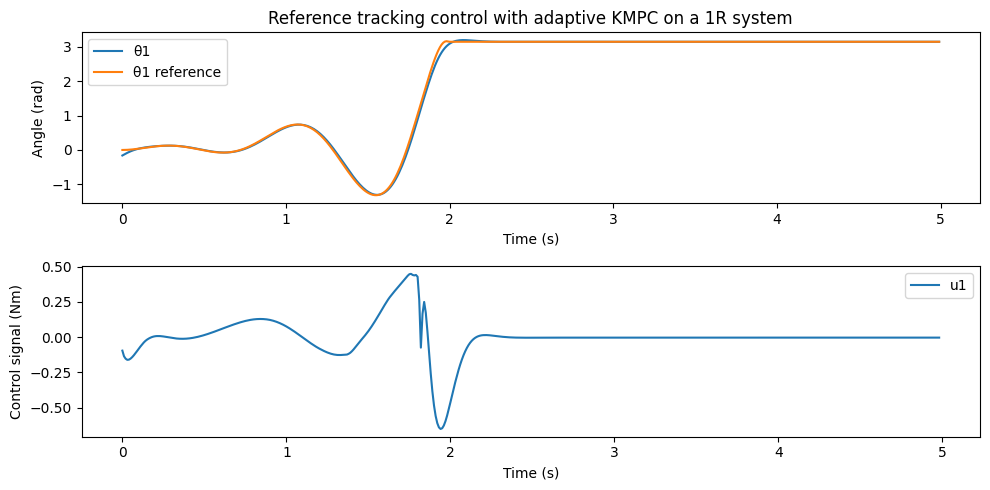

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.title("Reference tracking control with adaptive KMPC on a 1R system")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.subplot(2, 1, 2)
plt.xlabel("Time (s)")
plt.ylabel("Control signal (Nm)")
plt.grid()
plt.subplot(2, 1, 1)
plt.plot(T_a[0:], X_a[0,:], label="θ1")
plt.plot(np.concatenate([Tref[0:], [T_a[-1]]]), np.concatenate([Xref[:,0], [Xref[-1,0]]]), label="θ1 reference")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(T_a[0:-1], U_a[0,:], label="u1")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()